In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from datagen import DataGenerator

In [2]:
from shallow_models import ChangePointNet, ShallowRegressionModel, ConvAmplitudeEstimator, HybridAmplitudeEstimator

## Create train and val dataloader

In [3]:
def prepare_data(num_samples=1000, signal_length=100, seed=None):
    generator = DataGenerator(signal_length=signal_length, seed=seed)

    # Generate full dataset
    X_jump, (y_amp_jump, y_cp_jump) = generator.generate_data(num_samples // 2, jump=True)
    X_const, (y_amp_const, y_cp_const) = generator.generate_data(num_samples // 2, jump=False)

    # Convert everything to float32 explicitly
    X = torch.cat([X_jump, X_const], dim=0).float()
    y_amp = torch.cat([y_amp_jump, y_amp_const], dim=0).float()
    y_cp = torch.cat([y_cp_jump, y_cp_const], dim=0).float().unsqueeze(1)
    print(y_amp.shape, y_cp.shape)
    # y = torch.hstack([y_amp, y_cp])
    y = y_amp
    print(y.shape)

    # Shuffle dataset
    indices = torch.randperm(num_samples)
    # X, y_amp, y_cp = X[indices], y_amp[indices], y_cp[indices]
    X, y = X[indices], y[indices]

    return X, y


In [4]:
t1 = torch.arange(30).reshape((3,2,5))
t1[2, 0, -1] = 23
t1[2, 0, -2] = 24

channel_mins = t1.view(-1, t1.size(1), t1.size(2)).min(dim=2, keepdim=True)[0].min(dim=0, keepdim=True)[0]
channel_maxs = t1.view(-1, t1.size(1), t1.size(2)).max(dim=2, keepdim=True)[0].max(dim=0, keepdim=True)[0]

t1, channel_mins, channel_maxs

(tensor([[[ 0,  1,  2,  3,  4],
          [ 5,  6,  7,  8,  9]],
 
         [[10, 11, 12, 13, 14],
          [15, 16, 17, 18, 19]],
 
         [[20, 21, 22, 24, 23],
          [25, 26, 27, 28, 29]]]),
 tensor([[[0],
          [5]]]),
 tensor([[[24],
          [29]]]))

In [5]:
t2 = 2*(t1 - channel_mins) / (channel_maxs - channel_mins) - 1
t2

tensor([[[-1.0000, -0.9167, -0.8333, -0.7500, -0.6667],
         [-1.0000, -0.9167, -0.8333, -0.7500, -0.6667]],

        [[-0.1667, -0.0833,  0.0000,  0.0833,  0.1667],
         [-0.1667, -0.0833,  0.0000,  0.0833,  0.1667]],

        [[ 0.6667,  0.7500,  0.8333,  1.0000,  0.9167],
         [ 0.6667,  0.7500,  0.8333,  0.9167,  1.0000]]])

In [6]:
def prepare_dataloaders(num_samples=1000, signal_length=100, batch_size=32, train_ratio=0.8, seed=None):
    
    X, y = prepare_data(num_samples, signal_length, seed)

    num_samples = X.shape[0]
    # Train/validation split
    train_size = int(train_ratio * num_samples)
    val_size = num_samples - train_size

    # min-max norm
    # channel_mins = X.view(-1, X.size(1), X.size(2)).min(dim=2, keepdim=True)[0].min(dim=0, keepdim=True)[0]
    # channel_maxs = X.view(-1, X.size(1), X.size(2)).max(dim=2, keepdim=True)[0].max(dim=0, keepdim=True)[0]
    # print(X.shape, channel_maxs.shape, channel_mins.shape)
    # X = 2* (X - channel_mins) / (channel_maxs - channel_mins) - 1
    # y /= 1000
    

    # X_train, y_amp_train, y_cp_train = X[:train_size], y_amp[:train_size], y_cp[:train_size]
    # X_val, y_amp_val, y_cp_val = X[train_size:], y_amp[train_size:], y_cp[train_size:]
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:], y[train_size:]


    # Create datasets and dataloaders
    # train_dataset = TensorDataset(X_train, y_amp_train, y_cp_train)
    # val_dataset = TensorDataset(X_val, y_amp_val, y_cp_val)
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [43]:
train_loader, val_loader = prepare_dataloaders(batch_size=1024, signal_length=1024, seed=42, num_samples=100_000)

torch.Size([100000, 4]) torch.Size([100000, 1])
torch.Size([100000, 4])


In [9]:
dummy_data = next(iter(train_loader))
dummy_data

[tensor([[[  128.9844, -2362.7139, -1459.9290,  ..., -2437.4631,
            -418.7927, -1157.3844],
          [ 1056.9888,  -727.7728,  2172.7349,  ...,    67.7678,
             858.4960,  2347.1743]],
 
         [[-2390.9436, -1202.0691, -1325.5686,  ..., -1055.2358,
            -599.0897, -1452.9836],
          [  618.1628,  2084.3911,  2036.7823,  ...,   720.4336,
            1206.6832, -1961.8562]],
 
         [[-3103.1084,    10.3209,   225.3537,  ...,  1528.3220,
            -596.1711,  1947.2322],
          [-3144.9407, -1485.0723,  1882.6914,  ...,   590.9350,
           -1248.7214,   806.9880]],
 
         ...,
 
         [[ 1839.9446,  2439.5034, -1113.0316,  ...,   154.6573,
           -1434.8763,  -657.0364],
          [-1757.7847,  -792.8980, -1948.7908,  ...,  -227.3361,
            2054.6152, -2048.1638]],
 
         [[-1267.6646,  -120.8043,    81.7486,  ...,  2105.6465,
             842.1873,   770.4821],
          [ 1517.6880, -2825.4302,   210.3351,  ...,   728.3392

## Training functionality

In [10]:
def train_epoch(model, dataloader, optimizer, device, criterion):
    model.train()
    total_loss = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def validate(model, dataloader, device, criterion):
    model.eval()
    total_loss = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [11]:
# def train_epoch(model, dataloader, optimizer, device, amp_loss_fn, cp_loss_fn):
#     model.train()
#     total_loss = 0.0

#     for X, y_amp, y_cp in dataloader:
#         X, y_amp, y_cp = X.to(device).float(), y_amp.to(device).float(), y_cp.to(device).float()  # Explicit conversion

#         optimizer.zero_grad()
#         amp_pred, cp_pred, _ = model(X)

#         loss_amp = amp_loss_fn(amp_pred, y_amp)
#         loss_cp = cp_loss_fn(cp_pred, y_cp)
#         loss = loss_amp + loss_cp

#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * X.size(0)

#     avg_loss = total_loss / len(dataloader.dataset)
#     return avg_loss

# def validate(model, dataloader, device, amp_loss_fn, cp_loss_fn):
#     model.eval()
#     total_loss = 0.0

#     with torch.no_grad():
#         for X, y_amp, y_cp in dataloader:
#             X, y_amp, y_cp = X.to(device).float(), y_amp.to(device).float(), y_cp.to(device).float()  # Explicit conversion

#             amp_pred, cp_pred, _ = model(X)

#             loss_amp = amp_loss_fn(amp_pred, y_amp)
#             loss_cp = cp_loss_fn(cp_pred, y_cp)
#             loss = loss_amp + loss_cp

#             total_loss += loss.item() * X.size(0)

#     avg_loss = total_loss / len(dataloader.dataset)
#     return avg_loss


In [12]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    loss_fn,
    num_epochs=20,
    plot_loss=True,
    scheduler=None
):
    """
    Train the model and track performance metrics.

    Args:
        model (nn.Module): Model to train.
        train_loader (DataLoader): Training DataLoader.
        val_loader (DataLoader): Validation DataLoader.
        optimizer (Optimizer): Optimizer.
        device (torch.device): Device to run on (CPU/GPU).
        amp_loss_fn (Loss): Loss function for amplitude regression.
        cp_loss_fn (Loss): Loss function for change point localization.
        num_epochs (int): Number of training epochs.
        plot_loss (bool): Whether to plot loss curves.

    Returns:
        trained_model (nn.Module): Best trained model.
    """
    best_val_loss = float("inf")
    best_model_wts = model.state_dict()
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        train_loss = train_epoch(
            model, train_loader, optimizer, device, loss_fn
        )
        val_loss = validate(model, val_loader, device, loss_fn)

        if scheduler:
            scheduler.step(val_loss)
            print(scheduler.get_last_lr())

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    print("Training complete. Best Val Loss: {:.4f}".format(best_val_loss))

    if plot_loss:
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
        plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid()
        plt.show()

    return model

## Train

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ConvAmplitudeEstimator().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()
loss_fn = nn.SmoothL1Loss(reduction="mean")

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

cuda


Epoch [1/100]  Train Loss: 225.5332  Val Loss: 114.6694
Epoch [2/100]  Train Loss: 108.0407  Val Loss: 101.0840
Epoch [3/100]  Train Loss: 101.6085  Val Loss: 100.3405
Epoch [4/100]  Train Loss: 100.8917  Val Loss: 99.5735
Epoch [5/100]  Train Loss: 99.4937  Val Loss: 97.8928
Epoch [6/100]  Train Loss: 99.6094  Val Loss: 96.4950
Epoch [7/100]  Train Loss: 98.5504  Val Loss: 98.8090
Epoch [8/100]  Train Loss: 98.1393  Val Loss: 94.9783
Epoch [9/100]  Train Loss: 96.7218  Val Loss: 98.3948
Epoch [10/100]  Train Loss: 96.6129  Val Loss: 96.3920
Epoch [11/100]  Train Loss: 96.1363  Val Loss: 97.0098
Epoch [12/100]  Train Loss: 94.7769  Val Loss: 92.2687
Epoch [13/100]  Train Loss: 94.4419  Val Loss: 92.9994
Epoch [14/100]  Train Loss: 94.6002  Val Loss: 99.5759
Epoch [15/100]  Train Loss: 92.9362  Val Loss: 91.6507
Epoch [16/100]  Train Loss: 92.0620  Val Loss: 89.8438
Epoch [17/100]  Train Loss: 91.5040  Val Loss: 92.6380
Epoch [18/100]  Train Loss: 90.6489  Val Loss: 92.3978
Epoch [19/10

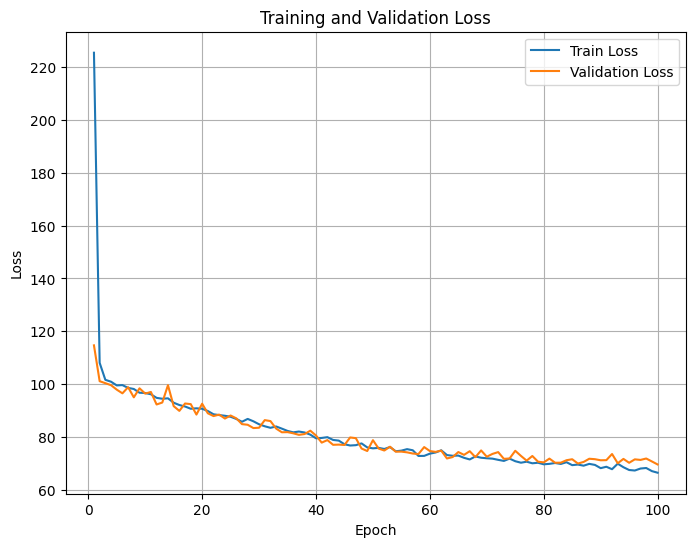

In [45]:
trained_model = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        device,
        loss_fn,
        num_epochs=100,
        scheduler=None
    )

Epoch [1/50]  Train Loss: 497.5276  Val Loss: 496.1043
Epoch [2/50]  Train Loss: 494.3061  Val Loss: 492.4260
Epoch [3/50]  Train Loss: 490.3104  Val Loss: 487.7196
Epoch [4/50]  Train Loss: 484.4805  Val Loss: 481.4544
Epoch [5/50]  Train Loss: 477.9102  Val Loss: 474.9497
Epoch [6/50]  Train Loss: 470.7656  Val Loss: 467.1810
Epoch [7/50]  Train Loss: 462.4945  Val Loss: 459.7184
Epoch [8/50]  Train Loss: 453.9301  Val Loss: 450.4464
Epoch [9/50]  Train Loss: 444.0140  Val Loss: 440.5491
Epoch [10/50]  Train Loss: 433.6930  Val Loss: 430.9294
Epoch [11/50]  Train Loss: 422.3568  Val Loss: 419.9570
Epoch [12/50]  Train Loss: 410.0327  Val Loss: 411.0474
Epoch [13/50]  Train Loss: 397.8089  Val Loss: 398.2797
Epoch [14/50]  Train Loss: 384.3447  Val Loss: 382.9458
Epoch [15/50]  Train Loss: 370.4696  Val Loss: 373.1486
Epoch [16/50]  Train Loss: 355.5238  Val Loss: 358.9761
Epoch [17/50]  Train Loss: 341.1290  Val Loss: 347.1563
Epoch [18/50]  Train Loss: 325.5352  Val Loss: 327.6632
E

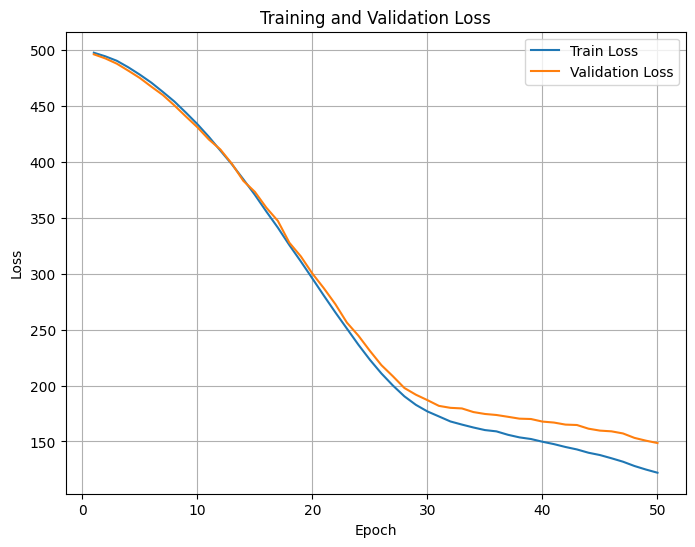

In [24]:
# min max
trained_model = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        device,
        loss_fn,
        num_epochs=50,
)

In [46]:
test_dummy = next(iter(val_loader))
test_dummy

[tensor([[[  412.5326,  1044.8502,  3383.5000,  ...,   389.0308,
            2302.8306,  2090.9807],
          [-3689.1165, -1882.6887, -2580.3711,  ...,   548.3765,
            1546.4662,   492.8730]],
 
         [[-4580.4570,  -639.8719, -1639.3787,  ...,  -226.7512,
            2637.4312,  -261.3783],
          [-2369.5605, -1827.5864,  -270.8712,  ...,  -413.3824,
             147.2126,   790.1420]],
 
         [[ -604.5973,    78.4499, -2429.5283,  ...,  1075.0100,
            -714.3705,   950.6298],
          [-1420.2917, -1526.1431,   789.9958,  ...,  2892.3044,
            2385.3015,  1681.0466]],
 
         ...,
 
         [[ 1515.6382, -1305.1649, -1470.6528,  ...,  2023.7288,
             345.7861, -1158.9478],
          [-1432.4238,  3551.0269,   765.5560,  ...,   517.2856,
           -1019.3369,   422.3452]],
 
         [[-2566.2554,   106.7396,  -856.2624,  ..., -1601.3398,
            -199.5312,  -561.4043],
          [ -261.8210,  -949.1569,   191.0331,  ..., -3228.3591

In [47]:
test_dummy[0].shape

torch.Size([1024, 2, 1024])

In [51]:
# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
# loss_fn = nn.SmoothL1Loss(reduction="mean")
true = test_dummy[1]

In [52]:
pred = trained_model(test_dummy[0].to(device))

In [ ]:
loss_fn(pred.to("cpu"), true)

tensor(72.4600, grad_fn=<MeanBackward0>)

In [ ]:
pred.to("cpu").detach().numpy()

array([[  855.6531 , -1105.3784 ,   573.40594,   685.8849 ],
       [-1072.0719 ,  -946.3866 ,  -185.22821,   705.5763 ],
       [ -670.8101 ,   128.30078,   529.9994 ,   271.50412],
       ...,
       [ -740.7236 ,   223.67116,   865.55396,   430.75656],
       [ -612.8369 ,  -192.07088,  -712.15015,  -169.17561],
       [  184.61249,   673.09045,   185.02272,   689.29944]],
      dtype=float32)

In [61]:
for pred_t, true_t in zip(pred, true):
    print(pred_t.to("cpu").detach().numpy(), "\t", true_t.to("cpu").detach().numpy())

[  855.6531  -1105.3784    573.40594   685.8849 ] 	 [ 818.195   -955.3411   544.9247   648.57623]
[-1072.0719   -946.3866   -185.22821   705.5763 ] 	 [-996.13574 -800.555   -131.94511  544.9084 ]
[-670.8101   128.30078  529.9994   271.50412] 	 [-585.642      59.855743  515.6283    209.56525 ]
[ -17.257288 -281.99194    17.59586  -274.66833 ] 	 [ -65.1602  -259.86496  -65.1602  -259.86496]
[ -19.542225 -706.0798   -694.34595  -888.8408  ] 	 [  98.26703 -759.06537 -811.7439  -945.9419 ]
[-718.904      83.980736   80.916     562.43665 ] 	 [-861.944    -78.12021  -32.27162  528.3306 ]
[-570.3252   796.04816 -553.7431   813.41644] 	 [-545.52277  813.99445 -545.52277  813.99445]
[-917.1459  545.0972 -895.9076  578.791 ] 	 [-903.68414  550.8167  -903.68414  550.8167 ]
[687.6907      4.6056232 713.5533     -9.56878  ] 	 [709.73474  25.82448 709.73474  25.82448]
[-702.3706    -15.209658 -700.12396   -31.551043] 	 [-700.2683    76.90512 -700.2683    76.90512]
[ -99.2504   533.0132  -541.6595  -9